Analyze the results of running cross-validation on DTD model rank

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd 
import wandb
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
def get_results_df(entity_project, config_keys, summary_keys):
    """Project is specified by <entity/project-name>"""
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(entity_project)

    run_results = {key: [] for key in itertools.chain(['name'], config_keys, summary_keys)}

    for run in runs: 

        # .summary contains the output keys/values for metrics like accuracy.
        # use .get to catch NaN runs (e.g. due to OOM)
        for key in summary_keys:
            run_results[key].append(run.summary.get(key,))

        # .config contains the hyperparameters.
        for key in config_keys:
            run_results[key].append(run.config[key])

        # .name is the human-readable name
        run_results['name'].append(run.name)

    return pd.DataFrame(run_results)

## 231022 run using mem-efficient full-batch EM

In [4]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eyz/kf-dtd-231022")

config_keys = ['k1', 'k2', 'k3']
summary_keys = ['pct_dev']

run_results = {key: [] for key in itertools.chain(['name'], summary_keys, config_keys)}

for run in runs: 

    # .summary contains the output keys/values for metrics like accuracy.
    # use .get to catch NaN runs (e.g. due to OOM)
    for key in summary_keys:
        run_results[key].append(run.summary.get(key,))

    # .config contains the hyperparameters.
    for key in config_keys:
        run_results[key].append(run.config[key])

    # .name is the human-readable name
    run_results['name'].append(run.name)

df = pd.DataFrame(run_results)


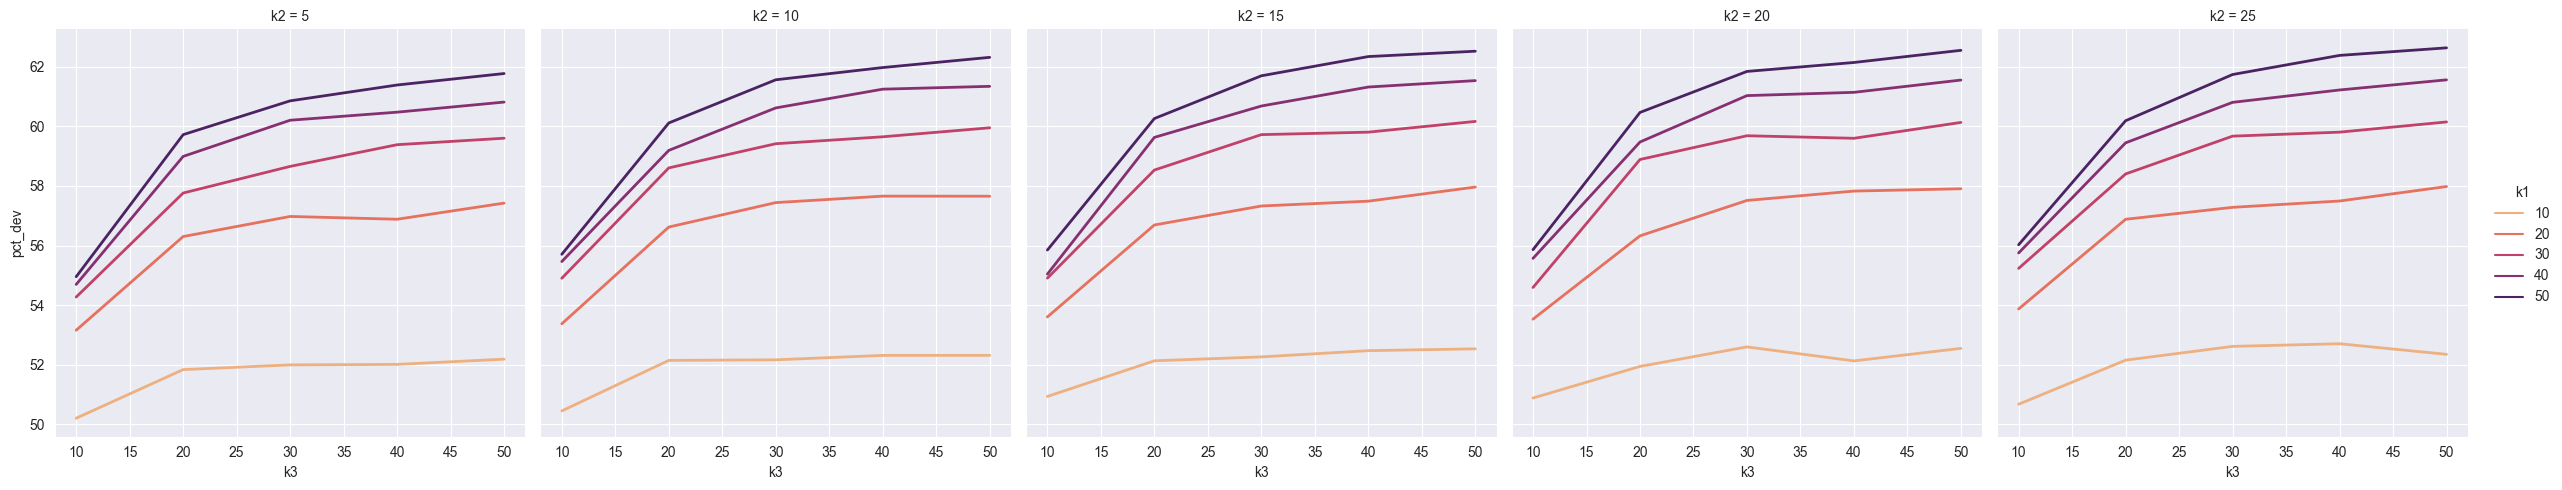

In [5]:
sns.set_style('darkgrid')
sns.relplot(df,  x='k3', y='pct_dev', col='k2', hue='k1', col_wrap=5, palette='flare', kind='line', legend='auto', lw=2);

In [9]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='k1', y='k3', z='pct_dev', color='k2', size_max=12, color_continuous_scale=px.colors.sequential.Purp,
                    width=800, height=500, title='20220608 10 minute bins')
fig.show()

## Preliminary 220608 run

In [7]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eyz/kf-dtd-220608")

config_keys = ['k1', 'k2', 'k3']
summary_keys = ['pct_dev']

run_results = {key: [] for key in itertools.chain(['name'], summary_keys, config_keys)}

for run in runs: 

    # .summary contains the output keys/values for metrics like accuracy.
    # use .get to catch NaN runs (e.g. due to OOM)
    for key in summary_keys:
        run_results[key].append(run.summary.get(key,))

    # .config contains the hyperparameters.
    for key in config_keys:
        run_results[key].append(run.config[key])

    # .name is the human-readable name
    run_results['name'].append(run.name)

df = pd.DataFrame(run_results)


We will visualize the cross-validation result by plotting `pct_dev` vs. `k3`,
varying `k1`, and enumerating out `k2`.

/Users/eyz/src/miniconda3/envs/dtd/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



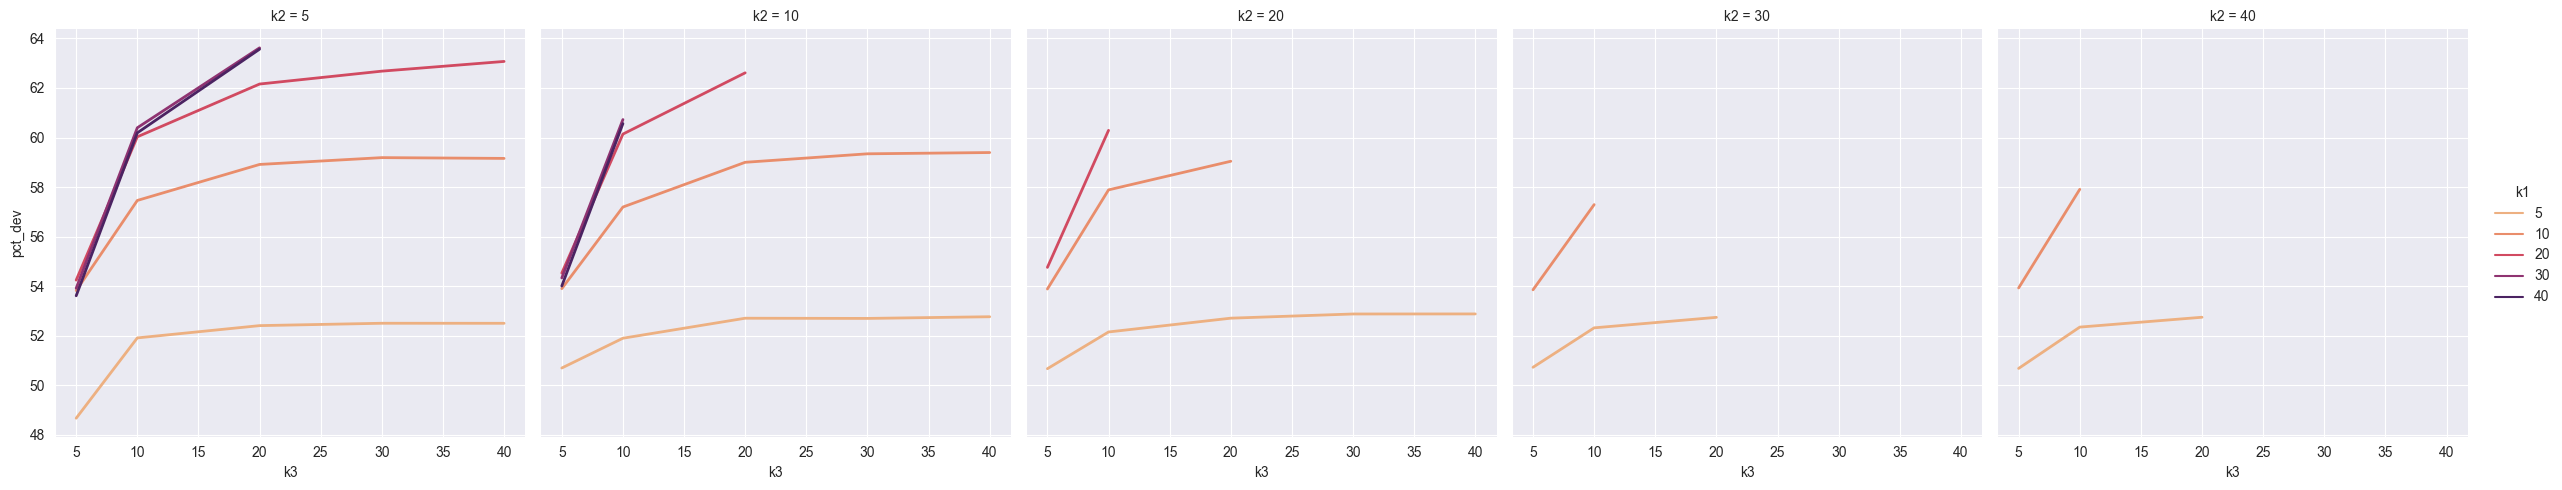

In [23]:
sns.set_style('darkgrid')
sns.relplot(df,  x='k3', y='pct_dev', col='k2', hue='k1', col_wrap=5, palette='flare', kind='line', legend='auto', lw=2);

In [17]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='k1', y='k3', z='pct_dev', color='k2', size_max=12, color_continuous_scale=px.colors.sequential.Purp,
                    width=800, height=500, title='20220608 10 minute bins')
fig.show()

## Final 230726 run

In [8]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eyz/kf-dtd-230726")

# config:epoch == n_epochs; summary:epoch = i_epoch
config_keys = ['k1', 'k2', 'k3', 'epoch', 'minibatch_size']
summary_keys = ['pct_dev', 'epoch_time [min]', 'total_time [min]']

df = get_results_df("eyz/kf-dtd-230726", config_keys, summary_keys)



## Estimate run-time based on linear assumptions 

In [64]:
# Estimating run-time based on linear assumptions

config_keys = ['k1', 'k2', 'k3', 'epoch', 'minibatch_size']
summary_keys = ['pct_dev', 'epoch_time [min]', 'total_time [min]']

df_23 = get_results_df("eyz/kf-dtd-230726", config_keys, summary_keys)
df_22 = get_results_df("eyz/kf-dtd-220608", config_keys, summary_keys)

df = pd.concat([df_23, df_22])

In [65]:
df['k_eff'] = df['k1'] * df['k2'] * df['k3']
df['minibatch_size'] = df['minibatch_size'].astype(str)
# df['projected_time [hr]'] = df['epoch_time [min]'] * df['epoch'] / 60

fig = px.scatter(df, x='k_eff', y='epoch_time [min]',
                 color='minibatch_size', symbol='minibatch_size', opacity=0.6,
                 trendline="ols", hover_data=['k1','k2','k3'])
fig.show()